In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
import json

In [3]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfl = tf.keras.layers

In [4]:
from lib.SBIGaussian import *
from lib.GaussianMixture import *

### Model construction
The following classes define the data generation process of a simple neural field model. Later the bias (NF2D.bias) will be reparametrised to a 4d-vector and regarded as our model parameters.

In [5]:
class BLNoise:
    """This generates smooth noise in space and time"""
    def __init__(self, in_size, out_size, name=None):
        self.in_size = in_size
        self.out_size = out_size
        Z_init = tf.complex(
            tf.random.normal(self.in_size),
            tf.random.normal(self.in_size))
        self.Z = tf.Variable(Z_init, name='Z')

    def __call__(self):
        nt, nx, ny = self.in_size
        nT, nX, nY = self.out_size
        Z_ = tf.pad(self.Z, [(0, nT-nt),(0, nX-nx),(0, nY-ny)])
        z = tf.math.real(tf.signal.fft3d(Z_))
        return z

In [6]:
class NF2D:
    """This solves our field equation numerically and applies the noise generated above"""
    def __init__(self, nt, nlat, nlon, dt: float=0.1, name=None):
        self.local_coupling = None
        self.dt = dt
        self.sqrt_dt = tf.sqrt(dt)
        self.half_dt = dt / 2
        self.nT, self.nlat, self.nlon = nt, nlat, nlon
        
        # diffusion kernel, could replace (or train!)
        K = np.c_[:self.nlat]*np.r_[:self.nlon]
        K = K / K.max()
        
        self.kernel = tf.convert_to_tensor(K.astype(np.complex64))
        self.bias = tf.zeros((self.nlat, self.nlon))
        self.weight = tf.constant(1.0)
        self.sigma = tf.constant(0.2)
    
    def __call__(self, zs):
        xs = [zs[0]*0 - 2.0]
        for t in range(1, self.nT):
            xs.append(self._heun(xs[-1], zs[t - 1]))
        return tf.stack(xs)
    
    def _euler(self, x, z):
        "Stochastic Euler method for diff eq _f."
        z_ = z * self.sqrt_dt * self.sigma
        dx1 = self._f(x)
        return x + self.dt*dx1 + z_
    
    def _heun(self, x, z):
        "Stochastic Heun method for diff eq _f."
        z_ = z * self.sqrt_dt * self.sigma
        dx1 = self._f(x)
        dx2 = self._f(x + self.dt * dx1 + z_)
        return x + self.half_dt*(dx1 + dx2) + z_

    def _f(self, x):
        "Bistable neural field with spatial bias."
        return x - x**3/3 + self.weight*self._lc(x) + self.bias
    
    def _lc(self, x):
        "Local field coupling w/ a kernel."
        X = tf.signal.fft2d(tf.cast(x, tf.complex64))
        cx = tf.signal.ifft2d(self.kernel * X)
        return tf.math.real(cx)

In [7]:
class LobeForward:
    """This enables us to extragt EEG-like data out ouf our neural field"""
    
    def __init__(self, nlat, nlon, name=None):
        self._init_lobe_geometry(nlat, nlon)
        self._init_contact_geometry()
        self._init_lobe_normals()
        self._init_gain_matrix()

    def _init_lobe_geometry(self, nlat, nlon):
        t = np.r_[:2*np.pi:1j*nlat]
        r = np.tanh(np.sin(6*t)*2)+2
        x, z = r*np.sin(t), r*np.cos(t)
        y = np.r_[x.min():x.max():1j*nlon]
        fxyz = np.zeros((nlat, nlon, 3))
        fxyz[..., 0] = x[:,None]
        fxyz[..., 1] = y
        fxyz[..., 2] = z[:,None]
        self.fxyz = fxyz
        self.x, self.y, self.z = x, y, z
    
    def _init_contact_geometry(self):
        # TODO update later
        cy = [-2, 1, -1, 2]
        cz = [2, 1, -1, -2]
        nc = 10
        cx = np.r_[self.x.min():self.x.max():1j*nc]
        o10 = np.ones(nc)
        cxyz = np.vstack([np.c_[cx, o10*cy_, o10*cz_] for cy_, cz_ in zip(cy,cz)])
        cx, cy, cz = cxyz.T
        self.cxyz = cxyz
        
    def _init_lobe_normals(self):
        def vd(x):
            dx = np.diff(x)
            return np.r_[(dx[0] + dx[-1])/2, (dx[1:]+dx[:-1])/2, (dx[0] + dx[-1])/2]
        dx = vd(self.x)
        dz = vd(self.z)
        self.nxy = np.c_[-dz, dx]

    def _init_gain_matrix(self):
        gain = np.zeros(self.fxyz.shape[:-1] + self.cxyz.shape[:1])
        Q = np.zeros_like(self.fxyz)
        Q[..., 0] = self.nxy[:,0][:,None]
        Q[..., 2] = self.nxy[:,1][:,None]
        for i, c in enumerate(self.cxyz):
            rr0 = c - self.fxyz
            gain[..., i] = np.sum(Q * rr0, axis=-1)
            gain[..., i] /= 1e-1 + np.linalg.norm(rr0, axis=-1)**3 # 4 pi sigma
        # permute axes for perf
        # (lat, lon, contact) -> (contact, lat*lon)
        gain = np.transpose(gain, (2, 0, 1)).reshape((len(self.cxyz), -1))
        # NB: transpose now because unlike numpy, tf.tranpose is O(n)
        self.gain = tf.convert_to_tensor(gain.astype('f').T)

    def __call__(self, xt):
        xt_ = tf.reshape(xt, (-1, fwd.gain.shape[0]))  # O(1)
        return tf.linalg.matmul(xt_, self.gain)

## Model Definition

In [8]:
nt, nlat, nlon = 64, 32, 32    #number of timesteps to simulate, width, height
fwd = LobeForward(nlat, nlon)  #neural field to EEG mapping

### Model Reparametrisation:

instead of the entire bias, shape = (nlat, nlot) wich is too big, we reparametrise the bias by the coordinates, the radius and the deviation of a pathological blob. The rest is normal distributed:

In [9]:
#shape(param) = (4,)
def get_bias(param):
    """This is the bias reparametrisation"""
    x = tf.math.sigmoid(param[0]) * nlat
    y = tf.math.sigmoid(param[1]) * nlon
    r = param[2] ** 2
    depth = param[3]
    
    bias = np.random.randn(nlat, nlon) / 10
    
    def fill(x_,y_):
        r2 = (x_-x)**2 + (y_-y)**2
        return np.exp(-r2/(r+0.01)) * depth
        
        
    overlay = np.fromfunction(fill, shape = (nlat, nlon))
    
    return tf.constant(bias + overlay)

In [10]:
def mech_model(theta):
    """This allows us to sample from our model with given model parameters"""
    noise = BLNoise((16, 4, 4), (nt, nlat, nlon))()
    nf = NF2D(nt, nlat, nlon)
    nf.bias = get_bias(theta)
    data = nf(noise)
    y = fwd(data)
    
    return y

### Example

<Figure size 432x288 with 0 Axes>

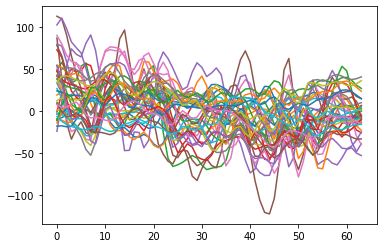

<Figure size 432x288 with 0 Axes>

In [11]:
data = mech_model(tf.constant([0.,0.,5,5]))
plt.plot(data)
plt.figure()

## Dataset
We first created a big dataset (sample from the joint distribution $P(x;\theta)$) and saved it to the hard drive. Later it can be reloaded and resampling is not needed for different trainig approaches -> faster

In [12]:
proposal_prior = tfd.Normal(loc = [0,0,9,8], scale = [1,1,1,1]) #the prior distribution of parameters

In [13]:
# N = 1e4
# def data_gen():
#     for i in range(int(N)):
#         theta = proposal_prior.sample()
#         s = mech_model(theta)
        
#         if i % (int(N)/1000) == 0:
#             print(i/N)
        
#         yield s, theta


# dataset = tf.data.Dataset.from_generator(data_gen, output_signature = (tf.TensorSpec(shape = (nt, 40)), tf.TensorSpec(shape = (4,))))

# tf.data.experimental.save(dataset, "data/MinFieldData_prior_mean_0_0_9_8_std_1_1_1_1")

In [14]:
dataset = tf.data.experimental.load("data/MinFieldData_prior_mean_0_0_9_8_std_1_1_1_1")

In [15]:
dataset = dataset.batch(70)

## GAN-Definition

In [16]:
class Generator(tf.Module):
    def __init__(self, param_dim, name = None):
        
        self.lstm1 = tfl.LSTM(units = 616)
        self.d1 = tfl.Dense(units = 64, activation = tf.nn.leaky_relu)
        self.d2 = tfl.Dense(units = 64, activation = tf.nn.leaky_relu)
        self.d3 = tfl.Dense(units = param_dim, activation = tf.nn.leaky_relu)
        
    @tf.function()
    def __call__(self, batch):
        
        #compress time dimension
        compressed = self.lstm1(batch)
        
        #apply first 2 layers
        
        x = self.d1(compressed)
        
        #inject noise and apply last layer
        x = x + tf.random.normal(shape = x.shape)
        
        x = self.d2(x)
        x = self.d3(x)
        
        return x

In [17]:
class Discriminator(tf.Module):
    def __init__(self, name = None):

        self.lstm1 = tfl.LSTM(units = 616)
        self.d1 = tfl.Dense(units = 128, activation = tf.nn.leaky_relu)
        self.d2 = tfl.Dense(units = 128, activation = tf.nn.leaky_relu)
        self.d3 = tfl.Dense(units = 1, activation = tf.math.sigmoid) #prob output
        
        #variance of high-d-noise to soften our generator-distribution
        self.noise_std = 0.01
        
    @tf.function()
    def __call__(self, batch_x, batch_theta):
        
        #compress time dimension
        compressed = self.lstm1(batch_x)
        
        #apply smoothing noise to parameters
        noised_theta = batch_theta + tf.random.normal(shape = batch_theta.shape, stddev = self.noise_std) #Wasserstein stuff/noising
        
        #merge the smoothed data input with the given theta-sample
        merged = tf.concat((compressed, noised_theta), axis = 1)
        
        #apply dense layers and output scalar
        x = self.d1(merged)
        x = self.d2(x)
        x = self.d3(x)
        
        return x

In [18]:
gen = Generator(param_dim = 4)

In [19]:
disc = Discriminator()

In [20]:
disc_opt = tf.optimizers.Adam(learning_rate = 0.001)
gen_opt = tf.optimizers.Adam(learning_rate = 0.001)
metrics = {"L": [], "prob_real": [], "prob_fake": [], "std_real": [], "std_fake": []}
catch = None, None

In [21]:
eps = 1e-5

def train_disc(batch_x, batch_theta):
    batch_theta_fake = gen(batch_x)
    
    def loss_():
        
        disc_out_real = disc(batch_x, batch_theta)
        disc_out_fake = disc(batch_x, batch_theta_fake)
        l = tf.reduce_mean(tf.math.log(disc_out_real + eps) + tf.math.log(1 - disc_out_fake + eps))
        
        
        if tf.math.is_nan(l):
            global catch
            catch = batch_x, batch_theta
            raise Exception("nan error")
            
            
        metrics["L"].append(l.numpy())
        
        metrics["prob_real"].append(tf.reduce_mean(disc_out_real))
        metrics["std_real"].append(tf.math.reduce_std(disc_out_real))
        
        metrics["prob_fake"].append(tf.reduce_mean(disc_out_fake))
        metrics["std_fake"].append(tf.math.reduce_std(disc_out_fake))
            
        return -l #bcs maximise l
    
    disc_opt.minimize(loss_, disc.trainable_variables)
    
def train_gen(batch_x, batch_theta):
    
    def loss_():
        batch_theta_fake = gen(batch_x)
        disc_out_real = disc(batch_x, batch_theta)
        disc_out_fake = disc(batch_x, batch_theta_fake)
        l = tf.reduce_mean(tf.math.log(disc_out_real + eps) + tf.math.log(1 - disc_out_fake + eps))
        
        
        if tf.math.is_nan(l):
            global catch
            catch = batch_x, batch_theta
            raise Exception("nan error")
            
            
        metrics["L"].append(l.numpy())
        
        metrics["prob_real"].append(tf.reduce_mean(disc_out_real))
        metrics["std_real"].append(tf.math.reduce_std(disc_out_real))
        
        metrics["prob_fake"].append(tf.reduce_mean(disc_out_fake))
        metrics["std_fake"].append(tf.math.reduce_std(disc_out_fake))
        
        return l #bcs minimise
    
    
    gen_opt.minimize(loss_, gen.trainable_variables)

Training Discr.: True


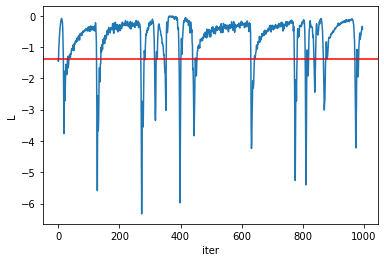

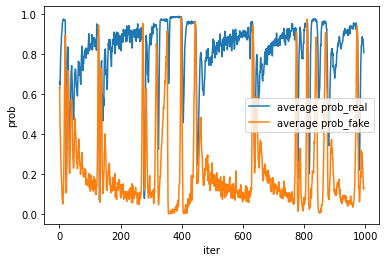

In [22]:
is_train_disc = True
i = 0

for _ in range(8):
    for batch_x, batch_theta in dataset:

        if is_train_disc:
            train_disc(batch_x, batch_theta)
        else:
            train_gen(batch_x, batch_theta)


        latest_L = metrics["L"][-1]
        latest_prob_real = metrics["prob_real"][-1]
        latest_prob_fake = metrics["prob_fake"][-1]
        if latest_prob_fake < 0.5 and latest_prob_real > 0.95:
            is_train_disc = False

        if latest_prob_fake > 0.8:
            is_train_disc = True

        if i < 5:
            is_train_disc = True

        if i % 5 == 0:
            clear_output()
            print("Training Discr.:", is_train_disc)

            plt.plot(metrics["L"])
            plt.axhline(y=-tf.math.log(4.), color='r', linestyle='-')
            plt.xlabel("iter")
            plt.ylabel("L")
            plt.show()

            plt.plot(metrics["prob_real"], label = "average prob_real")
            plt.plot(metrics["prob_fake"], label = "average prob_fake")
            plt.xlabel("iter")
            plt.ylabel("prob")
            plt.legend()
            plt.show()

        i += 1

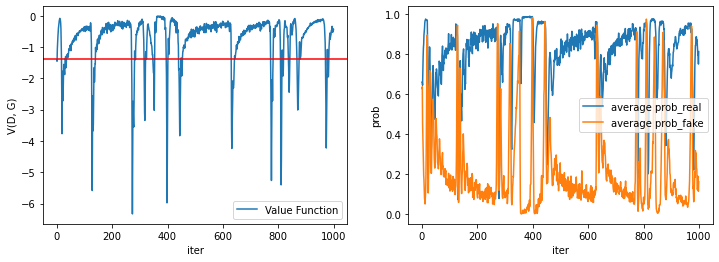

In [23]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(metrics["L"], label = "Value Function")
plt.axhline(y=-tf.math.log(4.), color='r', linestyle='-')
plt.xlabel("iter")
plt.ylabel("V(D, G)")
plt.legend()


plt.subplot(1,2,2)
plt.plot(metrics["prob_real"], label = "average prob_real")
plt.plot(metrics["prob_fake"], label = "average prob_fake")
plt.xlabel("iter")
plt.ylabel("prob")
plt.legend()

#plt.savefig("img/train.pdf")

## Observation
Now we can make a "real" observation. For this we sample from our prior and generate according data. Then we use this data to generate our trained posterior distribution. We sample from it (blue datapoints) and also visualise the position of the originally used parameters from our prior (orange).

Furthermore, we visualise both bias fields, one resulting out of our used parameters and the maximum-likelihood one in accordance to our posterior distribution. They should be similar.

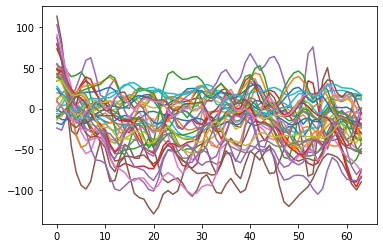

In [26]:
theta = proposal_prior.sample()
used_bias = get_bias(theta)


obs = mech_model(theta)
post_sample = gen(tf.repeat(tf.expand_dims(obs, axis = 0), axis = 0, repeats = 1000))

prior_sample = proposal_prior.sample(1000)

plt.plot(obs)
plt.show()

<Figure size 432x288 with 0 Axes>

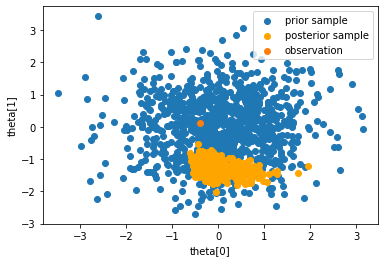

<Figure size 432x288 with 0 Axes>

In [27]:
plt.scatter(prior_sample[:,0], prior_sample[:,1], label = "prior sample")
plt.scatter(post_sample[:,0], post_sample[:,1], label = "posterior sample", color = "orange")
plt.scatter(theta[0], theta[1], label = "observation")
plt.xlabel("theta[0]")
plt.ylabel("theta[1]")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

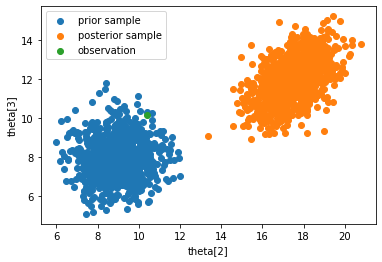

<Figure size 432x288 with 0 Axes>

In [28]:
plt.scatter(prior_sample[:,2], prior_sample[:,3], label = "prior sample")
plt.scatter(post_sample[:,2], post_sample[:,3], label = "posterior sample")
plt.scatter(theta[2], theta[3], label = "observation")
plt.xlabel("theta[2]")
plt.ylabel("theta[3]")
plt.legend()
plt.figure()

Text(0.5, 1.0, 'Used Bias')

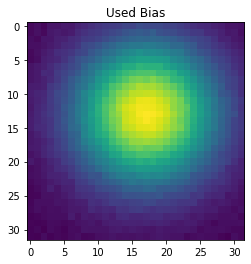

In [29]:
plt.imshow(used_bias)
plt.title("Used Bias")

Text(0.5, 1.0, 'Mean Posterior Bias')

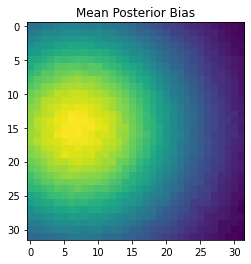

In [30]:
plt.imshow(get_bias(tf.reduce_mean(post_sample, axis = 0)))
plt.title("Mean Posterior Bias")

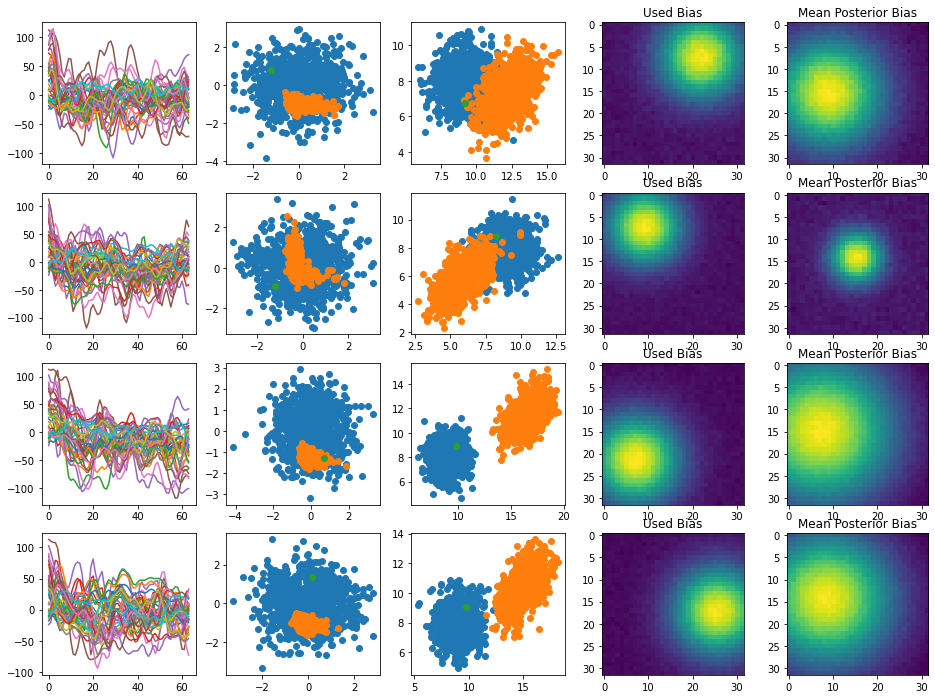

In [31]:
N = 4
plt.figure(figsize= (16,3.0 * N))

for i in range(N):
    theta = proposal_prior.sample()
    used_bias = get_bias(theta)


    obs = mech_model(theta)
    post_sample = gen(tf.repeat(tf.expand_dims(obs, axis = 0), axis = 0, repeats = 1000))

    prior_sample = proposal_prior.sample(1000)

    plt.subplot(N, 5, 5*i +1)
    plt.plot(obs)


    plt.subplot(N, 5, 5*i + 2)
    plt.scatter(prior_sample[:,0], prior_sample[:,1], label = "prior sample")
    plt.scatter(post_sample[:,0], post_sample[:,1], label = "posterior sample")
    plt.scatter(theta[0], theta[1], label = "observation")


    plt.subplot(N,5,5*i+3)
    plt.scatter(prior_sample[:,2], prior_sample[:,3], label = "prior sample")
    plt.scatter(post_sample[:,2], post_sample[:,3], label = "posterior sample")
    plt.scatter(theta[2], theta[3], label = "observation")


    plt.subplot(N,5,5*i+4)
    plt.imshow(used_bias)
    plt.title("Used Bias")

    plt.subplot(N,5,5*i+5)
    plt.imshow(get_bias(tf.reduce_mean(post_sample, axis = 0)))
    plt.title("Mean Posterior Bias")
    
#plt.savefig("img/sbi_GAN_result.pdf")

## Model Based Calibration

In [44]:
batch_x, batch_theta = None, None
for batch_x_, batch_theta_ in dataset.take(1):
    batch_x, batch_theta = batch_x_, batch_theta_

In [45]:
posteriors = tf.stack([gen(tf.repeat(tf.expand_dims(sample, axis = 0), axis = 0, repeats = 100)) for sample in batch_x], axis = 0)

In [46]:
posterior_dist_means = tf.reduce_mean(posteriors, axis = 1)
posterior_dist_vars = tf.math.reduce_std(posteriors, axis = 1)

In [47]:
z_score = tf.abs((posterior_dist_means - batch_theta) / posterior_dist_vars)

In [48]:
shrinkage = 1 - posterior_dist_vars / proposal_prior.variance()

In [49]:
tf.reduce_mean(shrinkage, axis = 0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.4020673 ,  0.45699972, -1.8473027 , -2.473054  ], dtype=float32)>

In [50]:
tf.reduce_mean(z_score, axis = 0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.4264733, 4.881097 , 1.6277152, 2.984854 ], dtype=float32)>

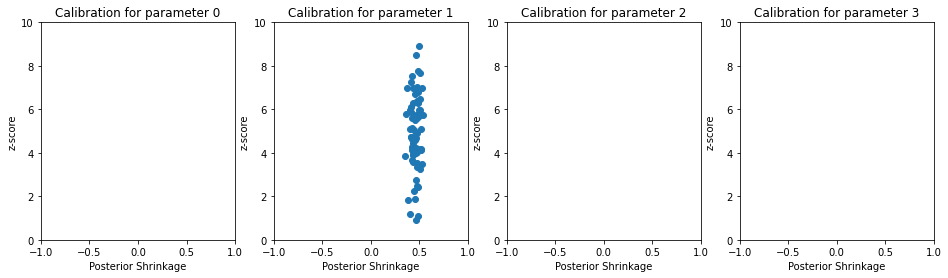

In [55]:
plt.figure(figsize = (16,4))

plt.subplot(1,4,1)
plt.scatter(shrinkage[:,0], z_score[:,0])
plt.xlabel("Posterior Shrinkage")
plt.ylabel("z-score")
plt.xlim([-1,1])
plt.ylim([0,10])
plt.title("Calibration for parameter 0")

plt.subplot(1,4,2)
plt.scatter(shrinkage[:,1], z_score[:,1])
plt.xlabel("Posterior Shrinkage")
plt.ylabel("z-score")
plt.xlim([-1,1])
plt.ylim([0,10])
plt.title("Calibration for parameter 1")

plt.subplot(1,4,3)
plt.scatter(shrinkage[:,2], z_score[:,2])
plt.xlabel("Posterior Shrinkage")
plt.ylabel("z-score")
plt.xlim([-1,1])
plt.ylim([0,10])
plt.title("Calibration for parameter 2")

plt.subplot(1,4,4)
plt.scatter(shrinkage[:,3], z_score[:,3])
plt.xlabel("Posterior Shrinkage")
plt.ylabel("z-score")
plt.xlim([-1,1])
plt.ylim([0,10])
plt.title("Calibration for parameter 3")

plt.savefig("img/GAN_calibration.pdf")

In [238]:
#not nice

## Save Model Params

In [222]:
# chkp_path = "checkpoints/gan/disc/"
# checkpoint = tf.train.Checkpoint(model=disc)
# checkpoint.write(chkp_path)

'checkpoints/gan/disc/'

In [223]:
# chkp_path = "checkpoints/gan/gen/"
# checkpoint = tf.train.Checkpoint(model=gen)
# checkpoint.write(chkp_path)

'checkpoints/gan/gen/'